# Introduction to TPI tool for the processing of MODIS data

**What does this notebook do?** 
This notebook demonstrates how to use the TPI tool to calculate Topographic Position Index (Weiss, 2001) from MODIS data.
The TPI tool is able to identify the local anomalies on the MODIS data (e.g, ocean currents, upwellings).

Weiss, A.D. (2001). Topographic Position and Landforms Analysis. In, ESRI International User Conference. San Diego, CA

**Requirements** 
You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set.

module use /g/data/v10/public/modules/modulefiles

module load dea

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository README for instructions on creating a Pull request).

**Date:** last updated 19th September, 2018

**Author:** Zhi Huang

### Import modules

**The TPI tool is implemented in the SpatialTools module with two functions: my_mean_filter and calculate_tpi. Please refer to the python scripts for further information.**

In [3]:
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
%matplotlib inline
import sys
import os
sys.path.append(os.path.expanduser('~/dea-notebooks/10_Scripts/'))
import SpatialTools

**Specify a development database to connect to. It is on a different database server agdcdev-db.nci.org.au, which means that your ~/.pgpass file will need to specify a password to connect to it as well.**

In [4]:
dc = Datacube(config='/g/data/u46/users/dra547/modis_oc.conf')

**The only product in this database is the daily ocean colour data between 2013 and 2016.**

**Load 15 days of SST (Sea Surface Temperature) and CHL_GSM (Chlorophyll _a_) data from the start of 2016. Note that the resolution has been resampled from 0.01 dd to 0.1 dd to save memory usage.**

In [5]:
data = dc.load(product='modis_oc_1d', time=('2016-01-01', '2016-01-15'), resolution=(-0.1, 0.1), measurements=('sst','chl_gsm'))

**Mask the nodata (-999) as 'nan'**

In [7]:
data = mask_invalid_data(data)

In [43]:
data

<xarray.Dataset>
Dimensions:    (latitude: 701, longitude: 1001, time: 15)
Coordinates:
  * time       (time) datetime64[ns] 2016-01-01T11:59:59.999999 ...
  * latitude   (latitude) float64 10.05 9.95 9.85 9.75 9.65 9.55 9.45 9.35 ...
  * longitude  (longitude) float64 79.95 80.05 80.15 80.25 80.35 80.45 80.55 ...
Data variables:
    sst        (time, latitude, longitude) float32 nan nan nan nan nan nan ...
    chl_gsm    (time, latitude, longitude) float32 nan nan nan nan nan nan ...
Attributes:
    crs:      EPSG:4326

**Try merging the data together every 5 days to fill in the gaps**

In [9]:
data2 = data.resample(time='5D').mean()

In [10]:
data2

<xarray.Dataset>
Dimensions:    (latitude: 701, longitude: 1001, time: 3)
Coordinates:
  * time       (time) datetime64[ns] 2016-01-01T11:59:59.999999 ...
  * latitude   (latitude) float64 10.05 9.95 9.85 9.75 9.65 9.55 9.45 9.35 ...
  * longitude  (longitude) float64 79.95 80.05 80.15 80.25 80.35 80.45 80.55 ...
Data variables:
    sst        (time, latitude, longitude) float32 nan nan nan nan nan nan ...
    chl_gsm    (time, latitude, longitude) float32 nan nan nan nan nan nan ...

**select the third 5-days composite**

In [11]:
data3 = data2.isel(time=2)

In [12]:
data3

<xarray.Dataset>
Dimensions:    (latitude: 701, longitude: 1001)
Coordinates:
    time       datetime64[ns] 2016-01-11T11:59:59.999999
  * latitude   (latitude) float64 10.05 9.95 9.85 9.75 9.65 9.55 9.45 9.35 ...
  * longitude  (longitude) float64 79.95 80.05 80.15 80.25 80.35 80.45 80.55 ...
Data variables:
    sst        (latitude, longitude) float32 nan nan nan nan nan nan nan nan ...
    chl_gsm    (latitude, longitude) float32 nan nan nan nan nan nan nan nan ...

**Use the TPI tool (i.e., calculte_tpi function) to calculate TPI values for the SST and CHL_GSM data.
The neighborhood is a circle with a radius of 10 cells, for example 1.0 dd in this case. 
This function returns a xarray.DataArray**

In [14]:
data3_sst_tpi = SpatialTools.calculte_tpi(data3.sst,neighborhood='Circle',radius=10)

In [15]:
data3_chl_gsm_tpi = SpatialTools.calculte_tpi(data3.chl_gsm,neighborhood='Circle',radius=10)

**Plot the TPI layer derived from the SST data**

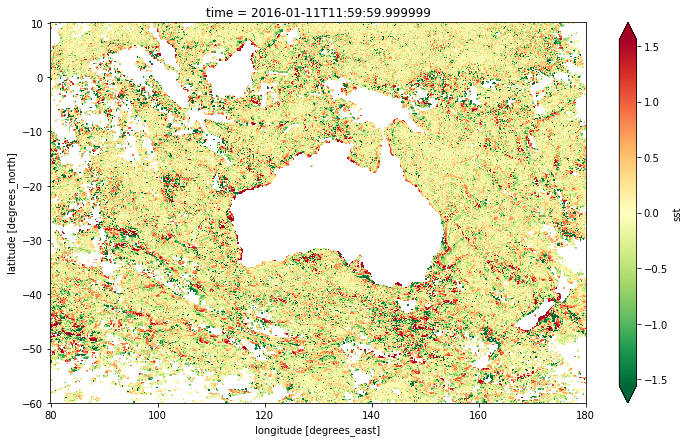

In [30]:
data3_sst_tpi.plot(figsize=(12,7),cmap='RdYlGn_r',robust=True)

**Plot the SST data for comparison**

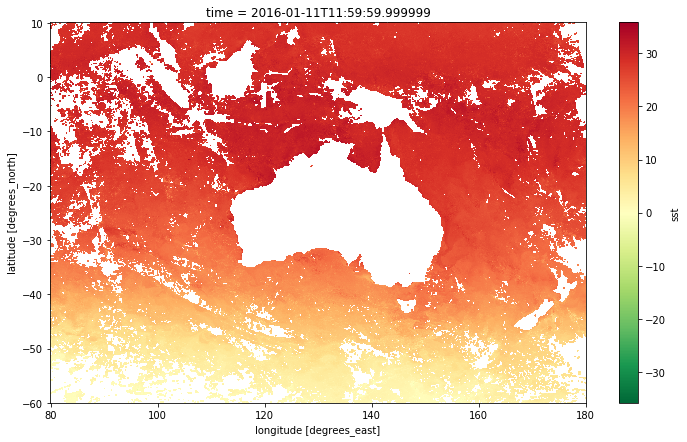

In [28]:
data3.sst.plot(figsize=(12,7),cmap='RdYlGn_r')

**Plot the tpi layer derived from the CHL_GSM data, and the CHL_GSM data for comparison**

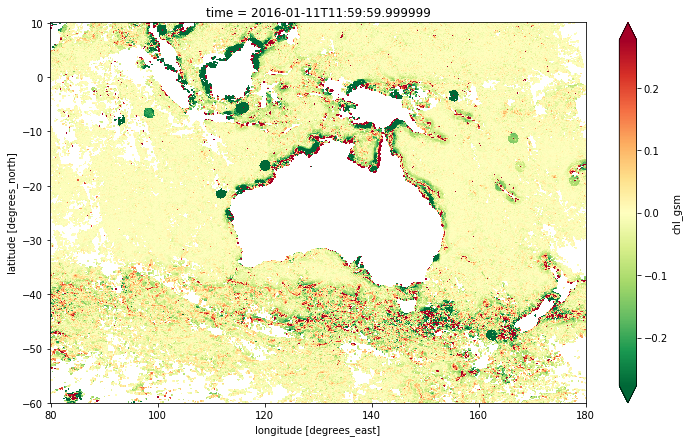

In [31]:
data3_chl_gsm_tpi.plot(figsize=(12,7),cmap='RdYlGn_r',robust=True)

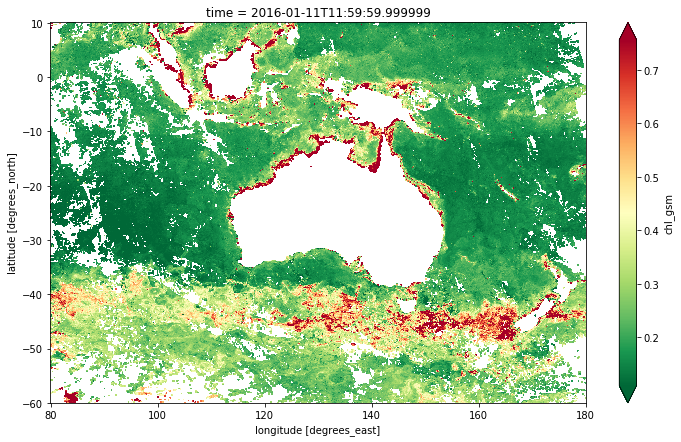

In [33]:
data3.chl_gsm.plot(figsize=(12,7),cmap='RdYlGn_r',robust=True)

### Zoom in to an area bounded by 30-40S and 130-150E. This area often features the Bonney Coast upwelling during summer time

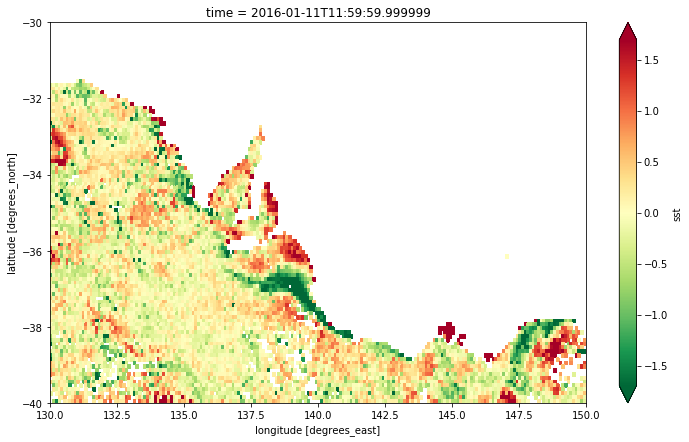

In [35]:
data3_sst_tpi.loc[-30:-40,130:150].plot(figsize=(12,7),cmap='RdYlGn_r',robust=True)

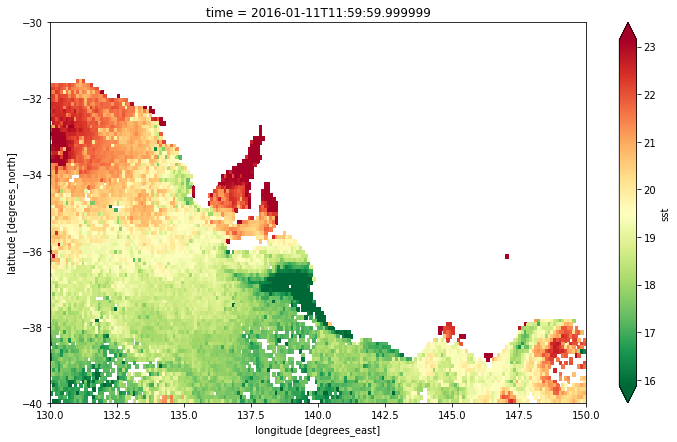

In [38]:
data3.sst.loc[-30:-40,130:150].plot(figsize=(12,7),cmap='RdYlGn_r',robust=True)

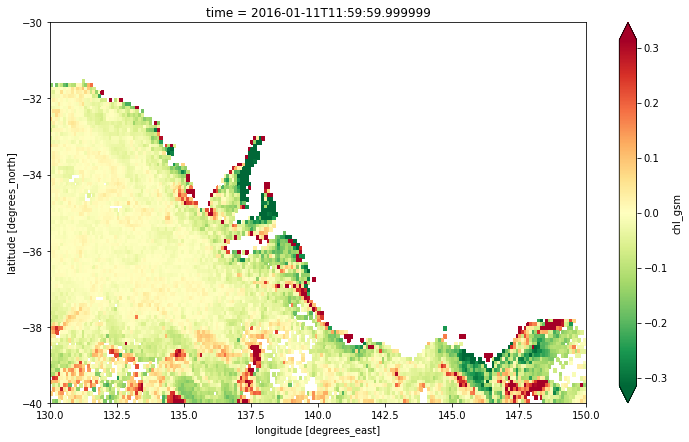

In [39]:
data3_chl_gsm_tpi.loc[-30:-40,130:150].plot(figsize=(12,7),cmap='RdYlGn_r',robust=True)

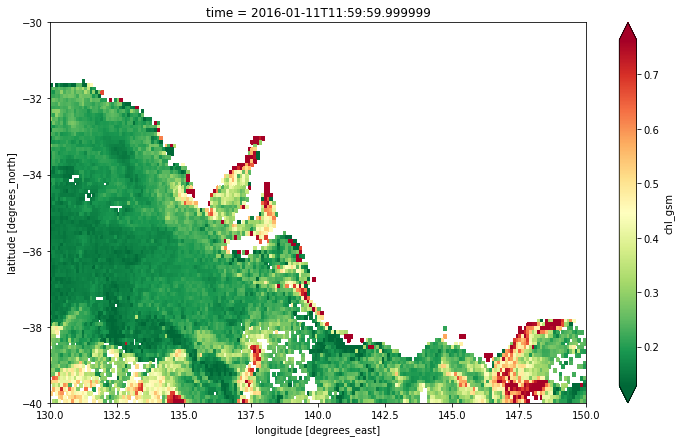

In [40]:
data3.chl_gsm.loc[-30:-40,130:150].plot(figsize=(12,7),cmap='RdYlGn_r',robust=True)